In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def map_plot(df):
    plt.plot(df['disc_tr_post'], df['acc_tr_post'], label='train')
    plt.plot(df['disc_te_post'], df['acc_te_post'], label='test')
    plt.xlabel('Discrimination')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

# COMPAS

### Correct
- Deprived: 1--no-white
- Positive class: 0-- no recidivate

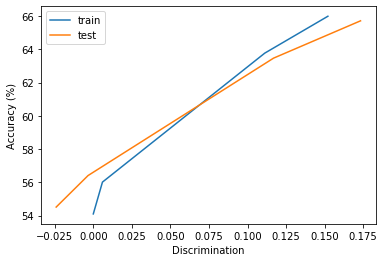

In [33]:
compas = pd.read_csv('compas-p0d1.csv')
compas = compas[compas['depth'] == 1]
compas = compas.groupby('epsilon').mean()
map_plot(compas)

### Incorrect

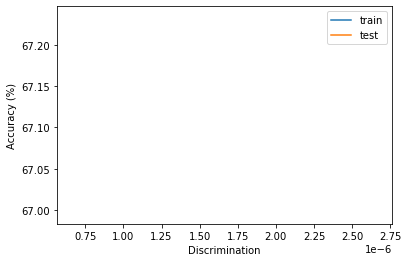

In [26]:
compas = pd.read_csv('compas-p2d1.csv')
compas = compas.groupby('epsilon').mean()
map_plot(compas)

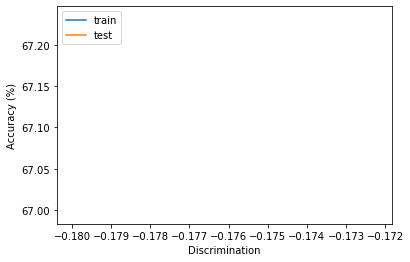

In [28]:
compas = pd.read_csv('compas-p1d1.csv')
compas = compas.groupby('epsilon').mean()
map_plot(compas)

# German
### Correct
- positive class: good credit
- deprived group: <= 25 age

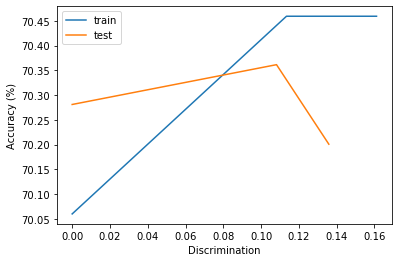

In [34]:
german = pd.read_csv('german-p1d1.csv')
german = german[german['depth'] == 1]
german = german.groupby('epsilon').mean()
map_plot(german)

### Incorrect

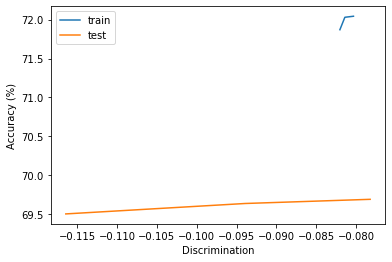

In [30]:
german = pd.read_csv('german-p1d2.csv')
german = german.groupby('epsilon').mean()
map_plot(german)

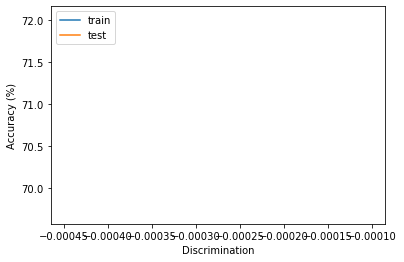

In [31]:
german = pd.read_csv('german-p2d1.csv')
german = german.groupby('epsilon').mean()
map_plot(german)

# Adult

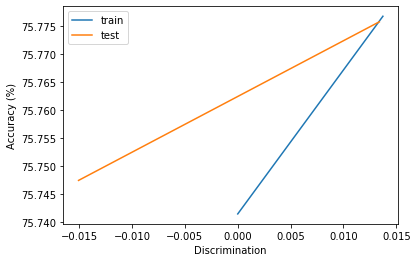

In [5]:
adult = pd.read_csv('adult-p2d1.csv')
adult = adult[adult['depth'] == 1]
adult = adult.groupby('epsilon').mean()
map_plot(adult)

In [27]:
adult = pd.read_csv('../DataSets/KamiranVersion/adult_train_calibration_enc_5.csv')

In [36]:
adult['target'].value_counts()

1    17007
2     5604
Name: target, dtype: int64

In [29]:
female = adult[adult['sex.1'] == 1]['target'].value_counts()
male = adult[adult['sex.1'] == 0]['target'].value_counts()

In [30]:
female[2] / (female[1] + female[2])

0.11363636363636363

In [31]:
male[2] / (male[1] + male[2])

0.31245495643058374

In [19]:
male

Series([], Name: target, dtype: int64)

In [32]:
adult = pd.read_csv('../DataSets/KamiranVersion/adult.csv')

In [33]:
adult['sex'].value_counts()

2    30527
1    14695
Name: sex, dtype: int64

In [34]:
adult = pd.read_csv('../DataSets/KamiranVersion/adult_train_calibration_5.csv')

In [35]:
adult['sex'].value_counts()

2    15263
1     7348
Name: sex, dtype: int64

# Comparing Kamiran's to FairOCT

In [99]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [100]:
header = pd.read_csv('../header_kamiran.csv')

In [101]:
header.columns

Index(['approach', 'data', 'sample', 'fair type', 'fair bound', 'nrow',
       'calibration_mode', 'depth', 'lambda', 'time limit', 'status',
       'obj val', 'train acc', 'gap', 'node count', 'solving time', 'test acc',
       'cal acc', 'sp train data', 'sp train pred', 'sp test data',
       'sp test pred', 'sp cal data', 'sp cal pred'],
      dtype='object')

In [147]:
compas_flowoct = pd.read_csv('Dec 29/FlowOCT Kamiran_version/Kamiran_limited-adult-2.csv', names=list(header.columns))

In [146]:
compas_flowoct

,approach,data,sample,fair type,fair bound,nrow,calibration_mode,depth,lambda,time limit,status,obj val,train acc,gap,node count,solving time,test acc,cal acc,sp train data,sp train pred,sp test data,sp test pred,sp cal data,sp cal pred
0,FlowOCT,adult_train_1.csv,1,None,1.00,22621,0,2,0.0,10800,9,17419.000000,0.770037,29.708939,26.0,10801.263797,0.769659,0.764058,0.200151,0.059015,0.200182,0.065206,0.200136,0.050538
1,FlowOCT,adult_train_1.csv,1,SP,0.01,22621,0,2,0.0,10800,9,16990.000000,0.751072,24.932313,1.0,10806.682891,0.751094,0.751061,0.200151,0.000000,0.200182,0.000000,0.200136,0.000000
2,FlowOCT,adult_train_1.csv,1,SP,0.02,22621,0,2,0.0,10800,9,16990.000000,0.751072,25.361978,1.0,10800.826362,0.751094,0.751061,0.200151,0.000000,0.200182,0.000000,0.200136,0.000000
3,FlowOCT,adult_train_1.csv,1,SP,0.03,22621,0,2,0.0,10800,9,16990.000000,0.751072,25.791642,1.0,10800.831422,0.751094,0.751061,0.200151,0.000000,0.200182,0.000000,0.200136,0.000000
4,FlowOCT,adult_train_1.csv,1,SP,0.04,22621,0,2,0.0,10800,9,17505.000000,0.773838,22.513568,1.0,10800.776721,0.769261,0.772679,0.200151,0.038681,0.200182,0.042583,0.200136,0.045603
5,FlowOCT,adult_train_1.csv,1,SP,0.05,22621,0,2,0.0,10800,9,16990.000000,0.751072,26.656857,1.0,10800.807658,0.751094,0.751061,0.200151,0.000000,0.200182,0.000000,0.200136,0.000000
6,FlowOCT,adult_train_1.csv,1,SP,0.06,22621,0,2,0.0,10800,9,16990.000000,0.751072,27.086521,1.0,10800.692588,0.751094,0.751061,0.200151,0.000000,0.200182,0.000000,0.200136,0.000000
7,FlowOCT,adult_train_1.csv,1,SP,0.07,22621,0,2,0.0,10800,9,16990.000000,0.751072,27.522072,1.0,10800.679586,0.751094,0.751061,0.200151,0.000000,0.200182,0.000000,0.200136,0.000000
8,FlowOCT,adult_train_1.csv,1,SP,0.08,22621,0,2,0.0,10800,9,17505.000000,0.773838,24.187375,1.0,10802.650348,0.769261,0.772679,0.200151,0.038681,0.200182,0.042583,0.200136,0.045603
9,FlowOCT,adult_train_1.csv,1,SP,0.09,22621,0,2,0.0,10800,9,16990.000000,0.751072,28.381401,1.0,10801.052635,0.751094,0.751061,0.200151,0.000000,0.200182,0.000000,0.200136,0.000000


In [150]:
kamiran = pd.read_csv('Kamiran/limited-adult-cart.csv')

In [186]:
sample = 4
fair_bound = 0.17
d=2

In [187]:
print(kamiran[(kamiran['sample'] == sample) & (kamiran['fair bound'] == fair_bound) \
              & (kamiran['depth'] == 2)][['test acc', 'sp test pred']])

     test acc  sp test pred
544    81.443       0.13789


In [188]:
print(compas_flowoct[(compas_flowoct['sample'] == sample) & (compas_flowoct['fair bound'] == fair_bound) \
              & (compas_flowoct['depth'] == 2)][['test acc', 'sp test pred']])

     test acc  sp test pred
520  0.803342      0.109503


In [18]:
kamiran['sp train pred'].value_counts()

0.200151    657
Name: sp train data, dtype: int64

In [167]:
kamiran_avg = kamiran[['train acc', 'sp train pred', 'test acc', 'sp test pred', 
         'depth', 'fair bound']].groupby(['depth', 'fair bound']).agg('mean').reset_index()

In [168]:
flowoct_avg = compas_flowoct[['train acc', 'sp train pred', 'test acc', 'sp test pred', 
         'depth', 'fair bound']].groupby(['depth', 'fair bound']).agg('mean').reset_index()
flowoct_avg['train acc'] = flowoct_avg['train acc']*100
flowoct_avg['test acc'] = flowoct_avg['test acc']*100

In [173]:
kamiran_avg

,depth,fair bound,train acc,sp train pred,test acc,sp test pred
0,1,0.01,74.6442,-3.848000e-07,74.6960,-0.013041
1,1,0.02,74.6442,-3.848000e-07,74.6960,-0.013041
2,1,0.03,75.9702,9.044215e-03,75.9902,0.008951
3,1,0.04,75.9702,9.044215e-03,75.9902,0.008951
4,1,0.05,77.0074,2.838502e-02,77.0580,0.033050
5,1,0.06,77.0074,2.838502e-02,77.0580,0.033050
6,1,0.07,77.0074,2.838502e-02,77.0580,0.033050
7,1,0.08,77.0074,2.838502e-02,77.0580,0.033050
8,1,0.09,77.0074,2.838502e-02,77.0580,0.033050
9,1,0.10,77.0074,2.838502e-02,77.0580,0.033050


In [170]:
print(kamiran_avg[(kamiran_avg['fair bound'] == fair_bound) \
              & (kamiran_avg['depth'] == 2)][['test acc', 'sp test pred']])

    test acc  sp test pred
94   80.7514      0.184936


In [171]:
print(flowoct_avg[(flowoct_avg['fair bound'] == fair_bound) \
              & (flowoct_avg['depth'] == 2)][['test acc', 'sp test pred']])

     test acc  sp test pred
39  80.472086      0.107312


In [91]:
def compare_methods(d, t, data, data2):
    compas_flowoct = pd.read_csv(f'Dec 29/FlowOCT Kamiran_version/Kamiran_{data}.csv', names=list(header.columns))
    kamiran = pd.read_csv(f'Kamiran/{data2}.csv')
    
    kamiran_avg = kamiran[['train acc', 'sp train pred', 'test acc', 'sp test pred', 
         'depth', 'fair bound']].groupby(['depth', 'fair bound']).agg('mean').reset_index()
    
    flowoct_avg = compas_flowoct[['train acc', 'sp train pred', 'test acc', 'sp test pred', 
         'depth', 'fair bound']].groupby(['depth', 'fair bound']).agg('mean').reset_index()
    flowoct_avg['train acc'] = flowoct_avg['train acc']*100
    flowoct_avg['test acc'] = flowoct_avg['test acc']*100
    
#     print(flowoct_avg)

    compas_flowoct_avg_d1 = flowoct_avg[flowoct_avg['depth'] == d]
    for i in [1, 2, 3]:
        kamiran_avg_d1 = kamiran_avg[kamiran_avg['depth'] == i]
        plt.plot(kamiran_avg_d1[f'sp {t} pred'], kamiran_avg_d1[f'{t} acc'], label=f'Kamiran (d={i+1})', marker='o')
    plt.plot(compas_flowoct_avg_d1[f'sp {t} pred'], compas_flowoct_avg_d1[f'{t} acc'], label='FairOCT (d=2)', marker='x')
    plt.legend()
    plt.xlabel('Discrimination (statistical parity)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{data2}_{t}')
    plt.savefig(f'../Plots/{data2}_{t}.pdf')
#     plt.title(f'Kamiran (d={d_k}), FairOCT (d={d})')
    plt.show()

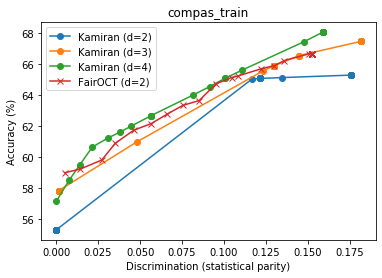

In [92]:
compare_methods(2, 'train', 'compas', 'compas')

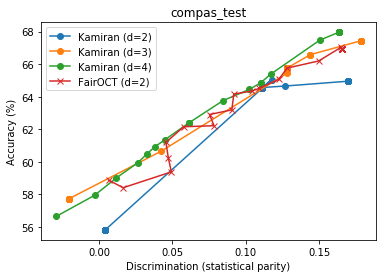

In [93]:
compare_methods(2, 'test', 'compas', 'compas')

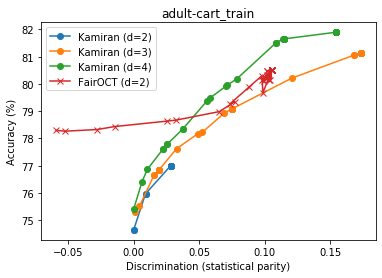

In [94]:
compare_methods(2, 'train', 'limited-adult-2', 'adult-cart')

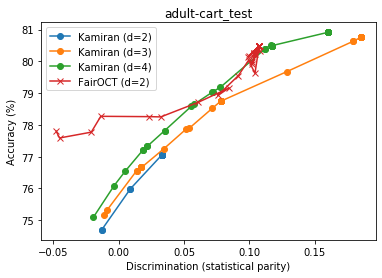

In [95]:
compare_methods(2, 'test', 'limited-adult-2', 'adult-cart')

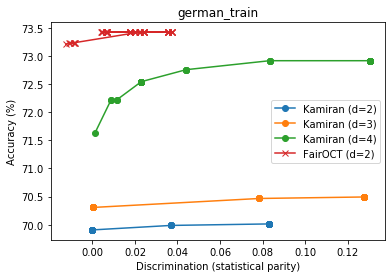

In [96]:
compare_methods(2, 'train', 'german', 'german')

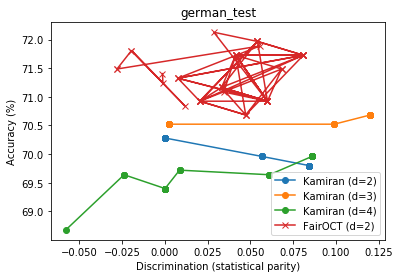

In [97]:
compare_methods(2, 'test', 'german', 'german')

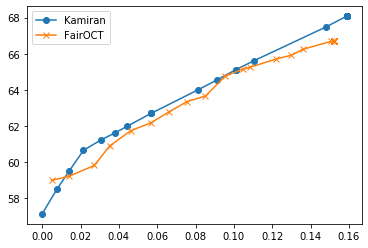

In [44]:
plt.plot(kamiran_avg_d1['sp train pred'], kamiran_avg_d1['train acc'], label='Kamiran', marker='o')
plt.plot(compas_flowoct_avg_d1['sp train pred'], compas_flowoct_avg_d1['train acc'], label='FairOCT', marker='x')
plt.legend()
plt.title('Kamiran (d=2), FairOCT (d=2)')
plt.show()
         
#          color='green', marker='o', linestyle='dashed'

Check if IGC, IGC+IGS, IGC-IGS are different

In [7]:
igc_path = 'igc_relab'
igcigs_path = 'igc+igs_relab'
igc_igs_path = 'igc-igs_relab'

fp = 'Kamiran/final'

dataset = 'compas'

header = pd.read_csv('Kamiran/header.csv')

df1 = pd.read_csv(f'{fp}/{igc_path}/{dataset}.csv', names=list(header.columns))
df2 = pd.read_csv(f'{fp}/{igcigs_path}/{dataset}.csv', names=list(header.columns))
df3 = pd.read_csv(f'{fp}/{igc_igs_path}/{dataset}.csv', names=list(header.columns))

In [16]:
def compare_methods(d, t, data, data2):
    header_flowoct = pd.read_csv('../header_kamiran.csv')
    compas_flowoct = pd.read_csv(f'Facct 2022 Final/Flow (Dec 29)/FlowOCT Kamiran_version/Kamiran_{data}.csv', names=list(header_flowoct.columns))

    
    flowoct_avg = compas_flowoct[['train acc', 'sp train pred', 'test acc', 'sp test pred', 
         'depth', 'fair bound']].groupby(['depth', 'fair bound']).agg('mean').reset_index()
    flowoct_avg['train acc'] = flowoct_avg['train acc']*100
    flowoct_avg['test acc'] = flowoct_avg['test acc']*100
    
#     print(flowoct_avg)
#     print(flowoct_avg)
    compas_flowoct_avg_d1 = flowoct_avg[flowoct_avg['depth'] == d]
#     print(compas_flowoct_avg_d1)
    for igc_path in ['igc_relab', 'igc+igs_relab', 'igc-igs_relab']:
        kamiran = pd.read_csv(f'{fp}/{igc_path}/{dataset}.csv', names=list(header.columns))
#         print(kamiran)

        kamiran_avg = kamiran[['train acc', 'sp train pred', 'test acc', 'sp test pred', 
             'depth', 'fair bound']].groupby(['depth', 'fair bound']).agg('mean').reset_index()
        kamiran_avg_d1 = kamiran_avg[kamiran_avg['depth'] == d-1]
#         print(kamiran_avg_d1)
        plt.plot(kamiran_avg_d1[f'sp {t} pred'], kamiran_avg_d1[f'{t} acc'], label=f'{igc_path} (d={d})', marker='o')
    plt.plot(compas_flowoct_avg_d1[f'sp {t} pred'], compas_flowoct_avg_d1[f'{t} acc'], label=f'FairOCT (d={d})', marker='x')
    plt.legend()
    plt.xlabel('Discrimination (statistical parity)')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{data2}_{t}')
#     plt.savefig(f'../Plots/{data2}_{t}.pdf')
#     plt.title(f'Kamiran (d={d_k}), FairOCT (d={d})')
    plt.show()

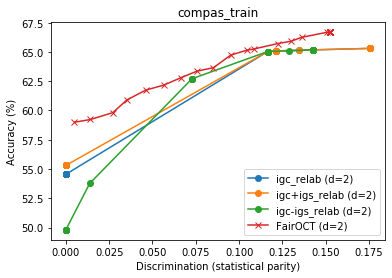

In [17]:
compare_methods(2, 'train', 'compas', 'compas')

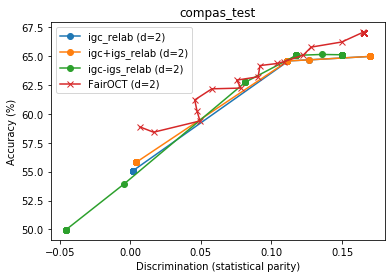

In [18]:
compare_methods(2, 'test', 'compas', 'compas')

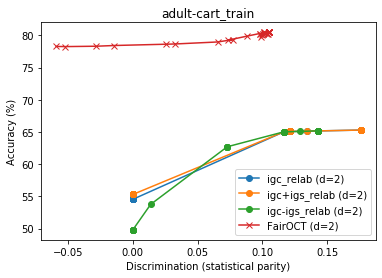

In [19]:
compare_methods(2, 'train', 'limited-adult-2', 'adult-cart')

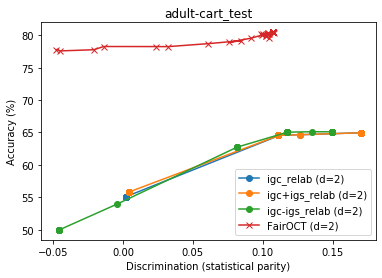

In [20]:
compare_methods(2, 'test', 'limited-adult-2', 'adult-cart')

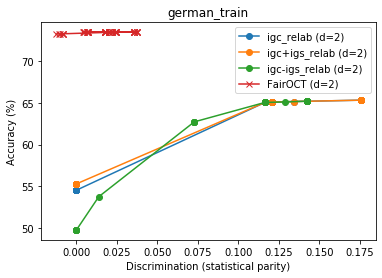

In [21]:
compare_methods(2, 'train', 'german', 'german')

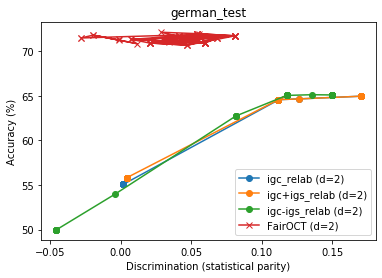

In [22]:
compare_methods(2, 'test', 'german', 'german')

In [205]:
df1

,sample,fair bound,depth,acc_tr_pre,disc_tr_pre,acc_te_pre,disc_te_pre,train acc,sp train pred,test acc,sp test pred
0,1,0.01,1,71.904,-3.736600e-03,73.494,3.590300e-02,71.904,-3.736600e-03,73.494,3.590300e-02
1,1,0.01,2,74.567,1.544800e-02,75.100,5.965700e-02,73.236,0.000000e+00,73.494,3.010100e-02
2,1,0.01,3,74.567,-9.018500e-04,73.092,5.471100e-03,74.567,-9.018500e-04,73.092,5.471100e-03
3,1,0.02,1,71.904,-3.736600e-03,73.494,3.590300e-02,71.904,-3.736600e-03,73.494,3.590300e-02
4,1,0.02,2,74.567,1.544800e-02,75.100,5.965700e-02,74.567,1.544800e-02,75.100,5.965700e-02
5,1,0.02,3,74.567,-9.018500e-04,73.092,5.471100e-03,74.567,-9.018500e-04,73.092,5.471100e-03
6,1,0.03,1,71.904,-3.736600e-03,73.494,3.590300e-02,71.904,-3.736600e-03,73.494,3.590300e-02
7,1,0.03,2,74.567,1.544800e-02,75.100,5.965700e-02,74.567,1.544800e-02,75.100,5.965700e-02
8,1,0.03,3,74.567,-9.018500e-04,73.092,5.471100e-03,74.567,-9.018500e-04,73.092,5.471100e-03
9,1,0.04,1,71.904,-3.736600e-03,73.494,3.590300e-02,71.904,-3.736600e-03,73.494,3.590300e-02


In [206]:
df2

,sample,fair bound,depth,acc_tr_pre,disc_tr_pre,acc_te_pre,disc_te_pre,train acc,sp train pred,test acc,sp test pred
0,1,0.01,1,69.907,9.992000e-16,70.281,5.551100e-16,69.907,9.992000e-16,70.281,5.551100e-16
1,1,0.01,2,70.040,2.465900e-01,71.084,1.048700e-01,69.907,9.992000e-16,70.281,5.551100e-16
2,1,0.01,3,70.306,2.473000e-01,69.478,1.118200e-01,70.040,0.000000e+00,65.863,-5.708700e-02
3,1,0.02,1,69.907,9.992000e-16,70.281,5.551100e-16,69.907,9.992000e-16,70.281,5.551100e-16
4,1,0.02,2,70.040,2.465900e-01,71.084,1.048700e-01,69.907,9.992000e-16,70.281,5.551100e-16
5,1,0.02,3,70.306,2.473000e-01,69.478,1.118200e-01,70.306,1.107200e-02,67.871,-1.275300e-02
6,1,0.03,1,69.907,9.992000e-16,70.281,5.551100e-16,69.907,9.992000e-16,70.281,5.551100e-16
7,1,0.03,2,70.040,2.465900e-01,71.084,1.048700e-01,69.907,9.992000e-16,70.281,5.551100e-16
8,1,0.03,3,70.306,2.473000e-01,69.478,1.118200e-01,70.306,1.107200e-02,67.871,-1.275300e-02
9,1,0.04,1,69.907,9.992000e-16,70.281,5.551100e-16,69.907,9.992000e-16,70.281,5.551100e-16


In [207]:
df3

,sample,fair bound,depth,acc_tr_pre,disc_tr_pre,acc_te_pre,disc_te_pre,train acc,sp train pred,test acc,sp test pred
0,1,0.01,1,71.904,-3.736600e-03,73.494,3.590300e-02,71.904,-3.736600e-03,73.494,3.590300e-02
1,1,0.01,2,74.834,1.215300e-02,75.100,4.980500e-02,73.502,0.000000e+00,73.896,4.082900e-02
2,1,0.01,3,76.165,1.486400e-02,75.904,3.446200e-03,76.032,0.000000e+00,75.502,8.372200e-03
3,1,0.02,1,71.904,-3.736600e-03,73.494,3.590300e-02,71.904,-3.736600e-03,73.494,3.590300e-02
4,1,0.02,2,74.834,1.215300e-02,75.100,4.980500e-02,74.834,1.215300e-02,75.100,4.980500e-02
5,1,0.02,3,76.165,1.486400e-02,75.904,3.446200e-03,76.165,1.486400e-02,75.904,3.446200e-03
6,1,0.03,1,71.904,-3.736600e-03,73.494,3.590300e-02,71.904,-3.736600e-03,73.494,3.590300e-02
7,1,0.03,2,74.834,1.215300e-02,75.100,4.980500e-02,74.834,1.215300e-02,75.100,4.980500e-02
8,1,0.03,3,76.165,1.486400e-02,75.904,3.446200e-03,76.165,1.486400e-02,75.904,3.446200e-03
9,1,0.04,1,71.904,-3.736600e-03,73.494,3.590300e-02,71.904,-3.736600e-03,73.494,3.590300e-02
